## Logistic Regression Experiments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import random
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
import optuna
from optuna.samplers import TPESampler
import joblib

In [2]:
random.seed(42)
np.random.seed(42)

- Load the train and test files 

In [3]:
train_df = pd.read_csv("train_data.csv")
val_df  = pd.read_csv("val_data.csv")
test_df  = pd.read_csv("test_data.csv")

In [4]:
print(f"Train: {len(train_df):>6} rows")
print(f" Val : {len(val_df):>6} rows")
print(f" Test: {len(test_df):>6} rows")

Train:   8000 rows
 Val :   1000 rows
 Test:   1000 rows


## DistilBERT (Extract embeddings using fine-tuned DistilBERT)

In [5]:
import pandas as pd
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.nn import CrossEntropyLoss
import evaluate
from sklearn.metrics import accuracy_score, classification_report
import torch
from transformers import AutoTokenizer, DistilBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib

- Fine-tuning DistilBERT

In [6]:
train_texts  = train_df["text"].tolist()
train_labels = train_df["sentiment_id"].tolist()
val_texts    = val_df["text"].tolist()
val_labels   = val_df["sentiment_id"].tolist()

In [7]:
cuda_available = torch.cuda.is_available()
mps_available  = getattr(torch.backends.mps, "is_available", lambda: False)()

if cuda_available:
    device = "cuda"
elif mps_available:
    device = "mps"
else:
    device = "cpu"
print("Using device:", device)

Using device: mps


In [8]:
# compute balanced class weights
classes = np.unique(train_labels)
weights = compute_class_weight("balanced", classes=classes, y=train_labels)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

In [9]:
# tokenize
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, padding=True, truncation=True)
val_encodings   = tokenizer(val_texts,   padding=True, truncation=True)

In [10]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset   = SentimentDataset(val_encodings, val_labels)

In [11]:
metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")
metric_f1        = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = metric_accuracy.compute(predictions=preds, references=labels)["accuracy"]
    prec = metric_precision.compute(
        predictions=preds,
        references=labels,
        average="macro"    
    )["precision"]
    rec = metric_recall.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )["recall"]
    f1 = metric_f1.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )["f1"]

  
    return {
        "Accuracy":  acc,
        "Precision": prec,
        "Recall":    rec,
        "F1":        f1,
    }

In [12]:
training_args = TrainingArguments(
    output_dir='./results_distilbert',
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="F1",
    greater_is_better=True,
    logging_dir="./logs",
)

In [13]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss

In [15]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.686100,0.612119,0.831000,0.751993,0.739468,0.698887
2,0.512400,0.723695,0.866000,0.733723,0.763174,0.745803
3,0.312700,1.003063,0.870000,0.739124,0.756015,0.746493


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TrainOutput(global_step=3000, training_loss=0.5037234191894531, metrics={'train_runtime': 2284.9233, 'train_samples_per_second': 10.504, 'train_steps_per_second': 1.313, 'total_flos': 3179274264576000.0, 'train_loss': 0.5037234191894531, 'epoch': 3.0})

In [17]:
# save best model and tokenizer
trainer.save_model("distilbert_experiment2")
tokenizer.save_pretrained("distilbert_experiment2")

('distilbert_experiment2/tokenizer_config.json',
 'distilbert_experiment2/special_tokens_map.json',
 'distilbert_experiment2/vocab.txt',
 'distilbert_experiment2/added_tokens.json',
 'distilbert_experiment2/tokenizer.json')

In [18]:
model     = DistilBertForSequenceClassification.from_pretrained("distilbert_experiment2").to(device)
tokenizer = AutoTokenizer.from_pretrained("distilbert_experiment2")

inference_trainer = Trainer(
    model=model,
    tokenizer=tokenizer)

/var/folders/28/58wf6pkn42zbxx3c6501tnnh0000gn/T/ipykernel_12792/1083177105.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  inference_trainer = Trainer(


In [19]:
# Run predict on validation dataset
pred_output = inference_trainer.predict(val_dataset)

# compute predictions
logits = pred_output.predictions      
y_true = pred_output.label_ids        
y_pred = np.argmax(logits, axis=1)    

# classification report
print(classification_report(y_true,y_pred,target_names=["Negative", "Neutral", "Positive"],digits=4))

              precision    recall  f1-score   support

    Negative     0.7911    0.7812    0.7862       160
     Neutral     0.4746    0.5545    0.5114       101
    Positive     0.9517    0.9323    0.9419       739

    accuracy                         0.8700      1000
   macro avg     0.7391    0.7560    0.7465      1000
weighted avg     0.8778    0.8700    0.8735      1000



- Extract train and validation embeddings using fine-tuned model 

In [20]:
# reload fine-tuned tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert_experiment2")
model     = DistilBertForSequenceClassification.from_pretrained("distilbert_experiment2").to(device)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [21]:
def get_embeddings(texts, batch_size=32):
    all_embeds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        enc = tokenizer(batch, return_tensors="pt",
                        padding=True, truncation=True).to(device)
        with torch.no_grad():
            out = model.distilbert(**enc) # run the encoder of fine-tuned distilbert
        cls_emb = out.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeds.append(cls_emb)
    return np.vstack(all_embeds)

In [23]:
X_train_embeds_1 = get_embeddings(train_texts)
joblib.dump(X_train_embeds_1, "X_train_embeds_distilbert_finetuned_experiment2.pkl")

2025-06-22 23:13:48.991 python[12792:392326] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-12792-2025-06-22_23_13_48-3783541687‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2025-06-22 23:13:48.999 python[12792:392326] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-12792-2025-06-22_23_13_48-101110446‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2025-06-22 23:13:49.002 python[12792:392326] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-12792-2025-06-22_23_13_49-4115919485‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2025-06-22 23:13:49.006 python[12792:392326] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-12792-2025-06-22_23_13_49-1455094593‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of 

['X_train_embeds_distilbert_finetuned_experiment2.pkl']

In [24]:
X_val_embeds_1   = get_embeddings(val_texts)
joblib.dump(X_val_embeds_1,   "X_val_embeds_distilbert_finetuned_experiment2.pkl")

['X_val_embeds_distilbert_finetuned_experiment2.pkl']

- Hyperparameter Tuning 

In [25]:
X_train_embeds_1 = joblib.load("X_train_embeds_distilbert_finetuned_experiment2.pkl")
X_val_embeds_1   = joblib.load("X_val_embeds_distilbert_finetuned_experiment2.pkl")

In [26]:
y_train = train_df["sentiment_id"]
y_val   = val_df  ["sentiment_id"]

In [27]:
def objective(trial):
    C       = trial.suggest_float("C", 1e-5, 1e2, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet"])
    
    if penalty == "l2":
        solver, l1_ratio = trial.suggest_categorical("solver", ["lbfgs","sag","saga"]), None
    elif penalty == "l1":
        solver, l1_ratio = "saga", None
    else:  
        solver, l1_ratio = "saga", trial.suggest_float("l1_ratio", 0.0, 1.0)
    
    params = {
        "C":            C,
        "penalty":      penalty,
        "solver":       solver,
        "class_weight": "balanced",
        "max_iter":     1000,
        "random_state": 42
    }
    if l1_ratio is not None:
        params["l1_ratio"] = l1_ratio

    clf = LogisticRegression(**params)
    clf.fit(X_train_embeds_1, y_train)
    preds = clf.predict(X_val_embeds_1)
    return f1_score(y_val, preds, average="macro")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  

print("Best macro-F1:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-06-22 23:17:57,026] A new study created in memory with name: no-name-b6e42e5d-6c92-429a-844c-0a13eefa910d
[I 2025-06-22 23:18:03,319] Trial 0 finished with value: 0.7337166040499019 and parameters: {'C': 0.007626683320182748, 'penalty': 'l1'}. Best is trial 0 with value: 0.7337166040499019.
/opt/miniconda3/envs/text/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-06-22 23:19:15,687] Trial 1 finished with value: 0.7233730579646845 and parameters: {'C': 22.316281203051535, 'penalty': 'elasticnet', 'l1_ratio': 0.27313819797392613}. Best is trial 0 with value: 0.7337166040499019.
/opt/miniconda3/envs/text/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-06-22 23:20:22,149] Trial 2 finished with value: 0.7393519532585544 and parameters: {'C

Best macro-F1: 0.7501831345709542
Best hyperparameters:
  C: 0.00028666124062889074
  penalty: l1


- Applying Optimal Parameters for Retraining and Evaluation on the Test Set

In [30]:
test_texts = test_df["text"].tolist()
y_test     = test_df["sentiment_id"].values

In [32]:
X_test_embeds_1 = get_embeddings(test_texts, batch_size=32)
joblib.dump(X_test_embeds_1,   "X_test_embeds_distilbert_finetuned_experiment2.pkl")

['X_test_embeds_distilbert_finetuned_experiment2.pkl']

In [33]:
# retreive train and test set embeddings
X_train_embeds_1 = joblib.load("X_train_embeds_distilbert_finetuned_experiment2.pkl")
X_test_embeds_1 = joblib.load("X_test_embeds_distilbert_finetuned_experiment2.pkl")

# Train Logistic Regression 
LR_distilbert_1 = LogisticRegression(
    C=0.00028666124062889074,
    penalty="l1",
    solver="saga",
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)
LR_distilbert_1.fit(X_train_embeds_1, y_train)

LogisticRegression(C=0.00028666124062889074, class_weight='balanced',
                   max_iter=1000, penalty='l1', random_state=42, solver='saga')

In [34]:
test_preds_1 = LR_distilbert_1.predict(X_test_embeds_1)

print(classification_report(
    y_test,
    test_preds_1,
    target_names=["Negative", "Neutral", "Positive"]
))

              precision    recall  f1-score   support

    Negative       0.77      0.81      0.79       160
     Neutral       0.57      0.54      0.56       101
    Positive       0.96      0.96      0.96       739

    accuracy                           0.89      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.89      0.89      0.89      1000



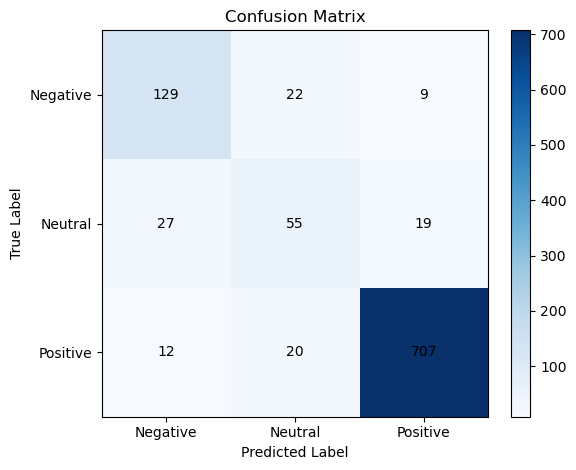

In [35]:
cm = confusion_matrix(test_df["sentiment_id"], test_preds_1)
labels = ["Negative", "Neutral", "Positive"]

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [36]:
# Save the trained model
joblib.dump(LR_distilbert_1, "LR_finetuned_distilbert_experiment2.pkl")

['LR_finetuned_distilbert_experiment2.pkl']

In [37]:
# Add predictions as a new column
test_df["FT_distilbert_pred"] = test_preds_1

# Save to CSV
test_df.to_csv("FT_distilbert_preds_experiment2.csv", index=False)

### Save full pipeline

In [38]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

LR_distilbert_1 = joblib.load("LR_finetuned_distilbert_experiment2.pkl")

class DistilBertVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, batch_size=32):
        self.batch_size = batch_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return get_embeddings(list(X), batch_size=self.batch_size)

pipeline_full = Pipeline([
    ("embed", DistilBertVectorizer(batch_size=32)),
    ("clf",   LR_distilbert_1)
])

joblib.dump(pipeline_full, "distilbert_lr_full_pipeline_experiment2.pkl")
print("Saved end-to-end pipeline to 'distilbert_lr_full_pipeline_experiment2.pkl'")

Saved end-to-end pipeline to 'distilbert_lr_full_pipeline_experiment2.pkl'
